# Import Libraries

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import TensorBoard
from keras.models import load_model

# Read the .csv file to learn about the data

In [3]:
df = pd.read_csv('../input/glaucoma-detection/glaucoma.csv', sep=',')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/glaucoma-detection/glaucoma.csv'

In [81]:
display(df.info())
print("\n")
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


None

Filename    0
ExpCDR      0
Eye         0
Set         0
Glaucoma    0
dtype: int64

we can see that there's no null data

# Let's see if the dataset is balanced

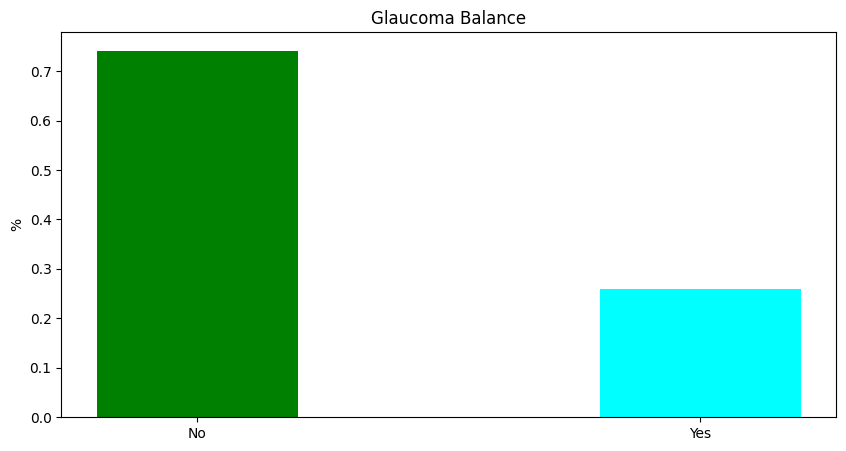

In [82]:
data = {'No': len(df.query('Glaucoma == 0')) / len(df),
        'Yes': len(df.query('Glaucoma == 1')) / len(df)
        }

fig = plt.figure(figsize=(10,5))
plt.title("Glaucoma Balance")
plt.bar(list(data.keys()), list(data.values()), color=['green', 'cyan'], width=0.4)
plt.ylabel("%")
plt.show()

print("\n")
plt.pie(list(data.values()), colors=['green', 'cyan'], labels=data.keys(), autopct='%.2f', )
plt.title('Glaucoma')
plt.show()

We can see from the charts that the dataset is heavily imbalanced; there are more cases with normal eyes than with glaucomatous eyes. This poses a problem because our machine learning models could become biased during training, favoring predictions for the majority class.

To address this issue, we're going to apply the undersampling technique, which involves reducing the number of samples in the majority class to match that of the minority class.

# UnderSampling Dataset

In [83]:
df1 = df.copy()
indices_normal = np.array(df1.query('Glaucoma == 0').index)
indices_glaucoma = np.array(df1.query('Glaucoma == 1').index)
df1.drop(indices_normal[:len(indices_normal)-len(indices_glaucoma)], axis=0, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1

Filename  ExpCDR Eye Set  Glaucoma
0    036.jpg  0.5097  OD   A         1
1    037.jpg  0.3647  OD   A         1
2    041.jpg  0.6131  OD   B         1
3    050.jpg  0.6957  OD   B         1
4    069.jpg  0.7986  OD   B         1
..       ...     ...  ..  ..       ...
331  646.jpg  0.6560  OD   A         1
332  647.jpg  0.7365  OD   A         1
333  648.jpg  0.5101  OS   A         1
334  649.jpg  0.5227  OD   B         0
335  650.jpg  0.6195  OS   B         1

[336 rows x 5 columns]

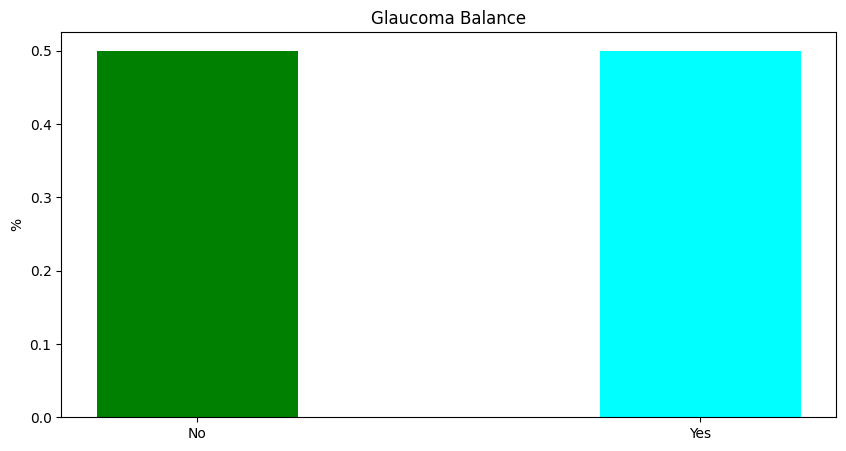

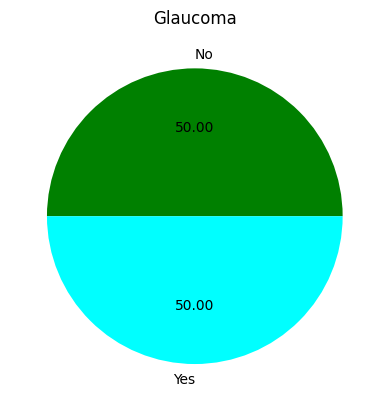

In [84]:
undersampled_data = {'No': len(df1.query('Glaucoma == 0')) / len(df1),
        'Yes': len(df1.query('Glaucoma == 1')) / len(df1)
        }

fig = plt.figure(figsize=(10,5))
plt.title("Glaucoma Balance")
plt.bar(list(undersampled_data.keys()), list(undersampled_data.values()), color=['green', 'cyan'], width=0.4)
plt.ylabel("%")
plt.show()

print("\n")
plt.pie(list(undersampled_data.values()), colors=['green', 'cyan'], labels=undersampled_data.keys(), autopct='%.2f', )
plt.title('Glaucoma')
plt.show()

The dataset is now balanced, so we no longer need to worry about the risk of biased models after the training process

# Create a directory with the undersampled dataset

In [85]:
import os
from PIL import Image

#Train
df_train = df1[:268]
df_train.reset_index(drop=True, inplace=True)
#Test
df_test = df1[268:]
df_test.reset_index(drop=True, inplace=True)

os.makedirs("../new_dataset/Train/negative", exist_ok=True)
os.makedirs("../new_dataset/Train/positive", exist_ok=True)
os.makedirs("../new_dataset/Test/negative", exist_ok=True)
os.makedirs("../new_dataset/Test/positive", exist_ok=True)

def create_undersampled_data(data, new_route):
    for i in range(len(data)):
        if data.loc[i].Glaucoma == 0:
            imagen = Image.open(f"../input/glaucoma-detection/ORIGA/ORIGA/Images/{data.loc[i].Filename}")
            imagen.save(f"{new_route}/negative/{data.loc[i].Filename}")
        else:
            imagen = Image.open(f"../input/glaucoma-detection/ORIGA/ORIGA/Images/{data.loc[i].Filename}")
            imagen.save(f"{new_route}/positive/{data.loc[i].Filename}")
        
train_route = "../new_dataset/Train"
test_route = "../new_dataset/Test"

create_undersampled_data(df_train, train_route) # Train
create_undersampled_data(df_test, test_route) # Test


# Load Images from disk

In [86]:
print('LOADING TRAIN IMAGES:\n')
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory = '../new_dataset/Train/',
    labels = 'inferred', #Los labels son generados tomando en cuenta la estructura del directorio
    label_mode = 'categorical', #Los labels los entregara de la forma = [[1], [0], [1],...] para una loss binary_crossentropy
    class_names = ['negative', 'positive'], #Solo valido cuando se tiene inferred. lista de nombre de las clases
    color_mode = 'rgb', #Default 'rgb' convertira las imagenes en 1, 3 o 4 canales (grayscale, rgb, rgba)
    batch_size = 32, # Default 32. None entrega el dataset con muestras individuales
    image_size = (224,224), #Default (256,256). redimensiona las imagenes despues de leerlas en disco. (altura, ancho)
    shuffle = True, #Default True. mezcla la data aleatoriamente
    seed = 42, #optional. establecer semilla para mezclar y aplicar transformaciones
    validation_split = 0.2, #optional. flotante entre 0 y 1 para reservar parte de la data para validacion
    subset = 'training', #subconjunto de la data que retorna. 'training', 'validation', 'both'(retorna tupla con 2 datasets).
    interpolation = 'bilinear', # Default bilinear. metodo para aplicar resize("bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian", "mitchellcubic")
    )
print('\n')
print('LOADING VALIDATION IMAGES:\n')
valid_dataset = keras.preprocessing.image_dataset_from_directory(
    directory='../new_dataset/Train/',
    labels="inferred",
    label_mode="categorical",
    class_names=['negative', 'positive'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation = 'bilinear'
)
print('\n')
print('LOADING TEST IMAGES:\n')
test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory='../new_dataset/Test/',
    labels="inferred",
    label_mode="categorical",
    class_names=['negative', 'positive'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation = 'bilinear'
)
print('\n')
print('IMAGES LOADED SUCCESFULLY.')

LOADING TRAIN IMAGES:

Found 268 files belonging to 2 classes.
Using 215 files for training.


LOADING VALIDATION IMAGES:

Found 268 files belonging to 2 classes.
Using 53 files for validation.


LOADING TEST IMAGES:

Found 68 files belonging to 2 classes.


IMAGES LOADED SUCCESFULLY.


# Normalize Images

In [87]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#Train_dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#Valid_dataset
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
#Test_dataset
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_image_batch, train_labels_batch = next(iter(train_dataset))
valid_image_batch, valid_labels_batch = next(iter(valid_dataset))
test_image_batch, test_labels_batch = next(iter(test_dataset))
train_first_image = train_image_batch[0]
valid_first_image = valid_image_batch[0]
test_first_image = test_image_batch[0]

# Verificar que los valores de los pixeles estan entre [0,1].
print(f'The min and max pixel values in train_dataset images are: {(np.min(train_first_image), np.max(train_first_image))}\n')
print(f'The min and max pixel values in valid_dataset images are: {(np.min(valid_first_image), np.max(valid_first_image))}\n')
print(f'The min and max pixel values in test_dataset images are: {(np.min(test_first_image), np.max(test_first_image))}')

The min and max pixel values in train_dataset images are: (0.0, 1.0)

The min and max pixel values in valid_dataset images are: (0.0, 1.0)

The min and max pixel values in test_dataset images are: (0.0, 1.0)


# View Images

In [88]:
def show_images(dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(5, 7, i + 1)
            plt.imshow(images[i].numpy())
            if np.argmax(labels[i]) == 0:
                plt.title("NORMAL")
            elif np.argmax(labels[i]) == 1:
                plt.title("GLAUCOMA")
            plt.axis("off")
    plt.show()

## Train Images

In [89]:
# display train images
show_images(train_dataset)

## Valid Images

In [90]:
# display valid images
show_images(valid_dataset)

## Test Images

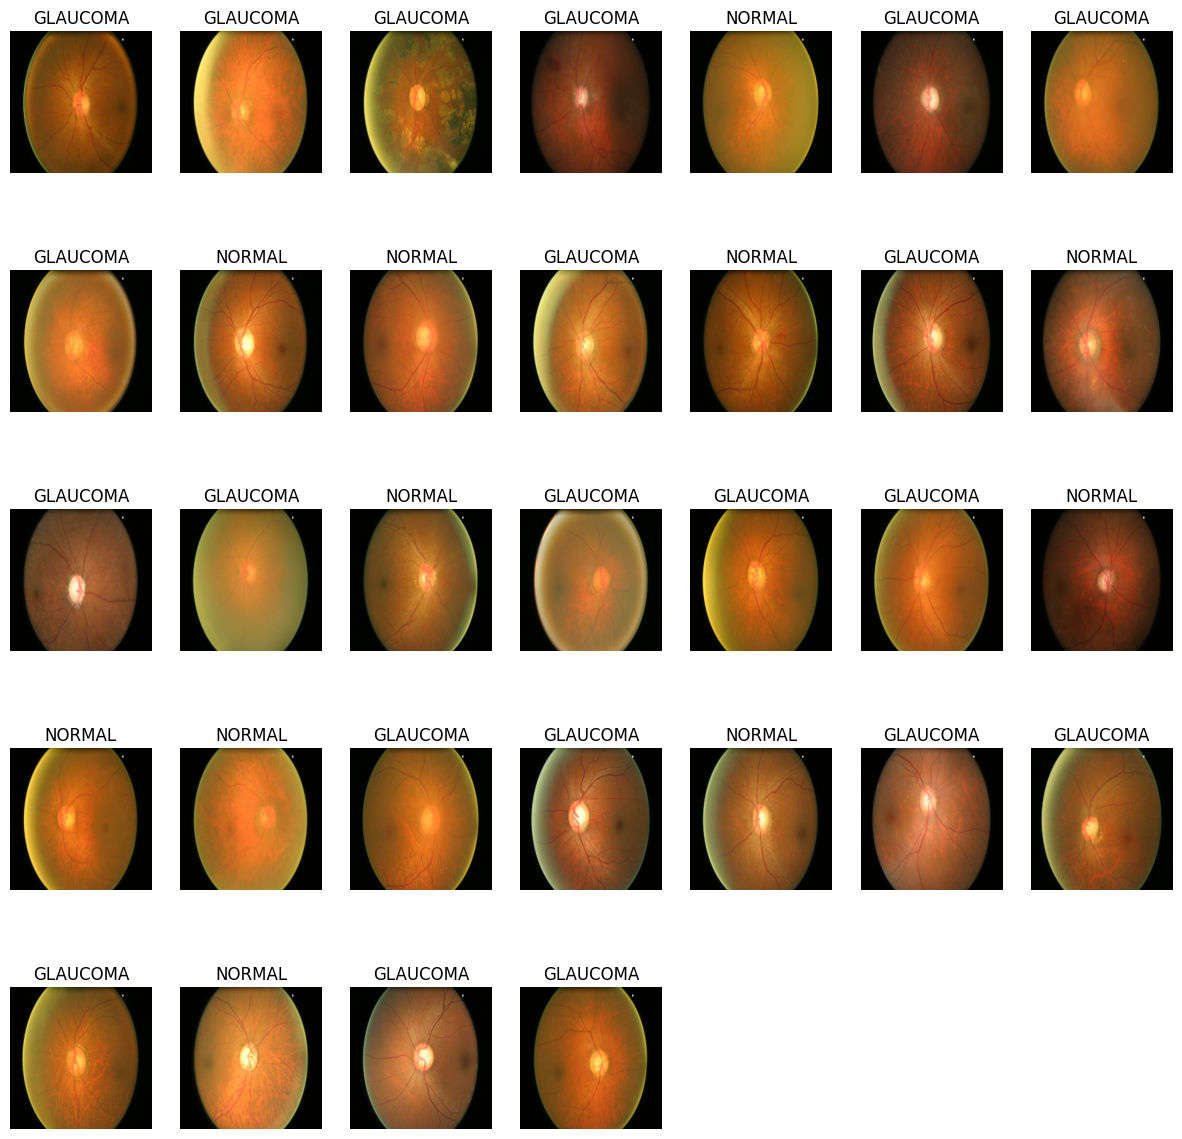

In [91]:
# display test images
show_images(test_dataset)

# Transfer Learning

## Download Models

In [92]:
vgg16 = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
vgg19 = keras.applications.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
densenet = keras.applications.DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)
efficientnet = keras.applications.EfficientNetB7(input_shape=(224,224,3), weights='imagenet', include_top=False)

base_models_dict = {
    'VGG16': vgg16,
    'VGG19': vgg19,
    'DenseNet': densenet,
    'EfficientNetB7': efficientnet
}
base_models_dict

#Freeze base_model's trainable parameters
for name, model in base_models_dict.items():
    model.trainable = False

## Build Models

In [93]:
FC_LAYERS = [1024, 512, 256]
dropout = 0.3

def build_model(base_model, fc_layers, dropout, name):
    
    feature_map = base_model.output
    x = GlobalAveragePooling2D()(feature_map)
    
    # add Dense Layers
    for neurons in fc_layers:
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout)(x)
    
    #Ouput layer
    output = Dense(2, activation='softmax')(x)
    
    model = keras.Model(inputs = base_model.input, outputs = output, name=name)
    
    return model

In [94]:
built_models_dict = {}
for name, model in base_models_dict.items():
    built_models_dict[name] = build_model(model, FC_LAYERS, dropout, 'built_'+name)
    
built_models_dict

{'VGG16': <Functional name=built_VGG16, built=True>,
 'VGG19': <Functional name=built_VGG19, built=True>,
 'DenseNet': <Functional name=built_DenseNet, built=True>,
 'EfficientNetB7': <Functional name=built_EfficientNetB7, built=True>}

## Built models arquitecture

In [95]:
# Lets see some models arquitectures
built_models_dict['VGG16'].summary()

Model: "built_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,896,642 (60.64 MB)

 Trainable params: 1,181,954 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile Models

In [96]:
for name, model in built_models_dict.items():
    model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=['accuracy'])

## Training

In [116]:
#this is for download files
import shutil
shutil.make_archive('logs', 'zip', '/kaggle/working/logs')

'/kaggle/working/logs.zip'

In [97]:
history_dict = {}
for name, model in built_models_dict.items():
    tb = TensorBoard(log_dir=f"./logs/{name}")
    print(f"Training {name}")
    history = model.fit(train_dataset, validation_data=(valid_dataset), epochs=30, callbacks=[tb])
    history_dict[name] = history
    print(f"{name} Training finished!")

Training VGG16
Epoch 1/30
1/7 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5625 - loss: 0.6785

W0000 00:00:1720569512.675704     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5790 - loss: 0.7525   

W0000 00:00:1720569520.502086     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720569521.758856     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5758 - loss: 0.7581 - val_accuracy: 0.4906 - val_loss: 0.9994
Epoch 2/30


W0000 00:00:1720569522.313448     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.5339 - loss: 0.8681 - val_accuracy: 0.6038 - val_loss: 0.6866
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.5297 - loss: 0.7163 - val_accuracy: 0.4906 - val_loss: 0.7146
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.5396 - loss: 0.7025 - val_accuracy: 0.5094 - val_loss: 0.6854
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.4427 - loss: 0.7469 - val_accuracy: 0.4906 - val_loss: 0.7224
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.5395 - loss: 0.7224 - val_accuracy: 0.6226 - val_loss: 0.6844
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.4997 - loss: 0.7028 - val_accuracy: 0.4906 - val_loss: 0.6921
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.5012 - loss: 0.7084 - val_accuracy: 0.6415 - val_loss: 0.6803
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.5805 - loss: 0.6825 - val_accuracy: 0.6038 - val_loss: 0.6784
Epo

W0000 00:00:1720569596.623570     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5519 - loss: 0.7462   

W0000 00:00:1720569604.678603     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720569605.969287     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5486 - loss: 0.7505 - val_accuracy: 0.5094 - val_loss: 0.6926
Epoch 2/30


W0000 00:00:1720569606.580933     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.4449 - loss: 0.8546 - val_accuracy: 0.5094 - val_loss: 0.7579
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.4821 - loss: 0.7738 - val_accuracy: 0.4906 - val_loss: 0.7087
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.5544 - loss: 0.7206 - val_accuracy: 0.5094 - val_loss: 0.6900
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.4831 - loss: 0.7352 - val_accuracy: 0.5094 - val_loss: 0.6894
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.5107 - loss: 0.7141 - val_accuracy: 0.4906 - val_loss: 0.7007
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.5122 - loss: 0.7020 - val_accuracy: 0.4906 - val_loss: 0.6997
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.5309 - loss: 0.6756 - val_accuracy: 0.5094 - val_loss: 0.6904
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.5567 - loss: 0.6882 - val_accuracy: 0.4906 - val_loss: 0.6991
Epo

W0000 00:00:1720569710.415202     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5609 - loss: 1.0738  

W0000 00:00:1720569724.682632     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720569734.245801     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.5570 - loss: 1.0942 - val_accuracy: 0.4906 - val_loss: 1.2412
Epoch 2/30


W0000 00:00:1720569739.815538     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.5177 - loss: 1.0060 - val_accuracy: 0.4906 - val_loss: 0.7318
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.5324 - loss: 0.7983 - val_accuracy: 0.7170 - val_loss: 0.6039
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.6017 - loss: 0.6953 - val_accuracy: 0.5472 - val_loss: 0.6693
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.7079 - loss: 0.6000 - val_accuracy: 0.6226 - val_loss: 0.6272
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.5983 - loss: 0.6648 - val_accuracy: 0.6226 - val_loss: 0.6313
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.6170 - loss: 0.6241 - val_accuracy: 0.6604 - val_loss: 0.5994
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.6301 - loss: 0.6447 - val_accuracy: 0.5472 - val_loss: 0.6944
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.6429 - loss: 0.6040 - val_accuracy: 0.6792 - val_loss: 0.5694
Epo

W0000 00:00:1720569939.013243     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4587 - loss: 0.9129  

W0000 00:00:1720570050.185880     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720570067.209045     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 271s 23s/step - accuracy: 0.4589 - loss: 0.9145 - val_accuracy: 0.5094 - val_loss: 0.7802
Epoch 2/30


W0000 00:00:1720570076.003104     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.5742 - loss: 0.7341 - val_accuracy: 0.4906 - val_loss: 0.7016
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.5022 - loss: 0.7189 - val_accuracy: 0.4906 - val_loss: 0.6980
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.4904 - loss: 0.7373 - val_accuracy: 0.5094 - val_loss: 0.6944
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.4675 - loss: 0.7214 - val_accuracy: 0.4906 - val_loss: 0.6932
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.5170 - loss: 0.7591 - val_accuracy: 0.5094 - val_loss: 0.6935
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.5796 - loss: 0.6981 - val_accuracy: 0.4906 - val_loss: 0.7011
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.5302 - loss: 0.7411 - val_accuracy: 0.5094 - val_loss: 0.6930
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.4835 - loss: 0.7211 - val_accuracy: 0.4906 - val_loss: 0.6932
Epo

# Plot Metrics

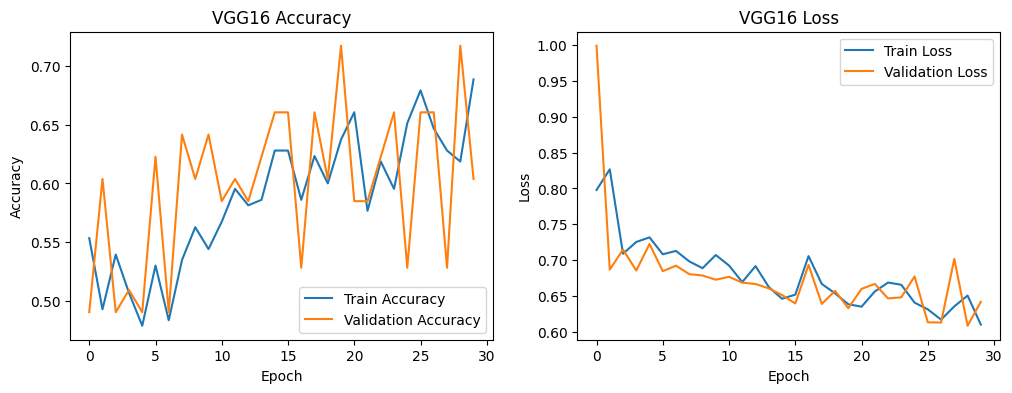

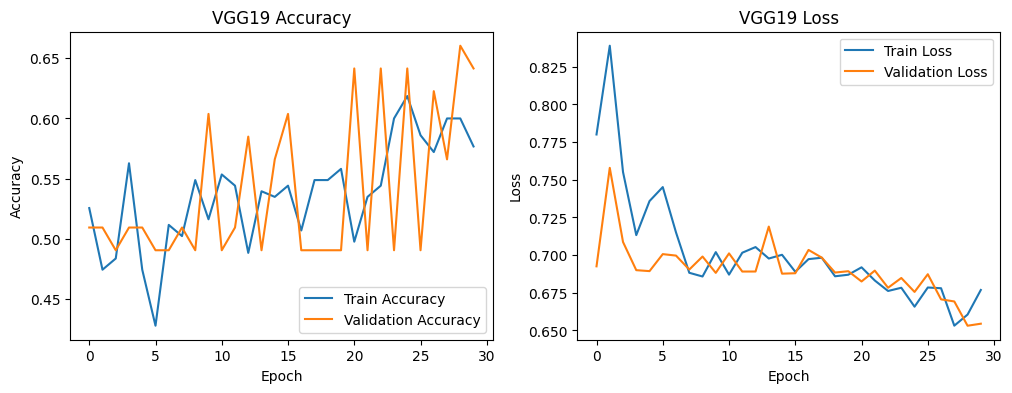

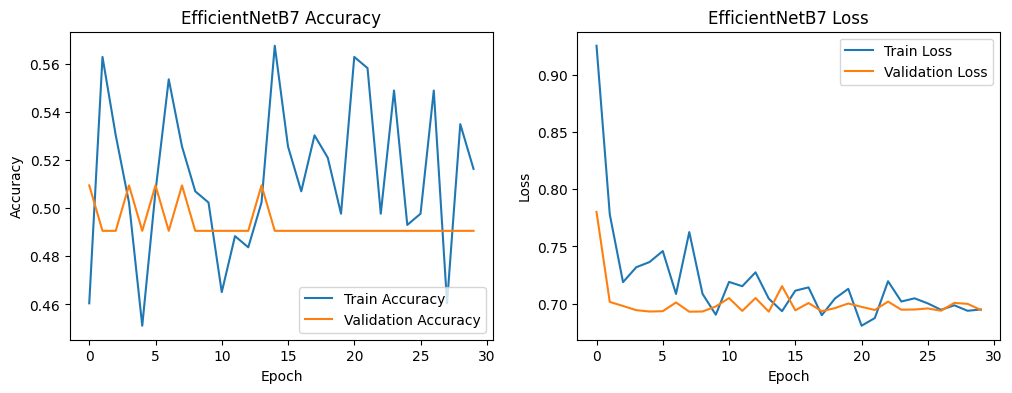

In [98]:
def plot_history(history, model_name):
    # Resumir la historia de la precisión
    plt.figure(figsize=(12, 4))

    # Gráfico de la precisión (accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Gráfico de la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Iterar sobre el diccionario para generar los gráficos para cada modelo
for model_name, history in history_dict.items():
    plot_history(history, model_name)

In [99]:
acc_values = []
val_acc_values = []
loss_values = []
val_loss_values = []

for model, history in history_dict.items():
    acc_values.append(history.history['accuracy'][-1])
    val_acc_values.append(history.history['val_accuracy'][-1])
    loss_values.append(history.history['loss'][-1])
    val_loss_values.append(history.history['val_loss'][-1])
    

In [100]:
metrics = {"Model": list(built_models_dict.keys()),
     "Accuracy": acc_values,
     "Val_accuracy": val_acc_values,
     "Loss": loss_values,
     "Val_loss": val_loss_values}

metrics = pd.DataFrame(data=metrics)

metrics

Model  Accuracy  Val_accuracy      Loss  Val_loss
0           VGG16  0.688372      0.603774  0.609829  0.641571
1           VGG19  0.576744      0.641509  0.676872  0.654491
2        DenseNet  0.753488      0.698113  0.490893  0.542898
3  EfficientNetB7  0.516279      0.490566  0.694996  0.694562

## Save Models

In [101]:
built_models_dict

{'VGG16': <Functional name=built_VGG16, built=True>,
 'VGG19': <Functional name=built_VGG19, built=True>,
 'DenseNet': <Functional name=built_DenseNet, built=True>,
 'EfficientNetB7': <Functional name=built_EfficientNetB7, built=True>}

In [102]:
#Save VGG16
built_models_dict['VGG16'].save('vgg16.keras')

#Save VGG19
built_models_dict['VGG19'].save('vgg19.keras')

#Save DenseNet
built_models_dict['DenseNet'].save('densenet.keras')

#Save EfficientNetB7
built_models_dict['EfficientNetB7'].save('efficientnet.keras')

In [39]:
model = keras.saving.load_model('name.keras')

# Get all model's metrics

## Get Predictions & true labels

In [114]:
dummy_vgg16_predictions = []
dummy_vgg19_predictions = []
dummy_densenet_predictions = []
dummy_efficientnet_predictions = []
dummy_y_true = []

for batch, labels in test_dataset:
    dummy_vgg16_predictions.append(built_models_dict['VGG16'].predict(batch, verbose=0))
    dummy_vgg19_predictions.append(built_models_dict['VGG19'].predict(batch, verbose=0))
    dummy_densenet_predictions.append(built_models_dict['DenseNet'].predict(batch, verbose=0))
    dummy_efficientnet_predictions.append(built_models_dict['EfficientNetB7'].predict(batch, verbose=0))
    dummy_y_true.append(labels.numpy())

last_labels = dummy_y_true.pop()
last_vgg16_predictions = dummy_vgg16_predictions.pop()
last_vgg19_predictions = dummy_vgg19_predictions.pop()
last_densenet_predictions = dummy_densenet_predictions.pop()
last_efficientnet_predictions = dummy_efficientnet_predictions.pop()

vgg16_predictions = np.array(dummy_vgg16_predictions).reshape(-1,2)
vgg19_predictions = np.array(dummy_vgg19_predictions).reshape(-1,2)
densenet_predictions = np.array(dummy_densenet_predictions).reshape(-1,2)
efficientnet_predictions = np.array(dummy_efficientnet_predictions).reshape(-1,2)

y_true = np.array(dummy_y_true).reshape(-1,2)

vgg16_predictions = np.concatenate((vgg16_predictions, last_vgg16_predictions), axis=0)
vgg19_predictions = np.concatenate((vgg19_predictions, last_vgg19_predictions), axis=0)
densenet_predictions = np.concatenate((densenet_predictions, last_densenet_predictions), axis=0)
efficientnet_predictions = np.concatenate((efficientnet_predictions, last_efficientnet_predictions), axis=0)
y_true = np.concatenate((y_true, last_labels), axis=0)

In [115]:
#Save results

np.save('predictions_vgg16.npy', vgg16_predictions)
np.save('predictions_vgg19.npy', vgg19_predictions)
np.save('predictions_densenet.npy', densenet_predictions)
np.save('predictions_efficientnet.npy', efficientnet_predictions)
np.save('true_labels.npy', y_true)

In [5]:
vgg16_predictions_prob = np.load("./arrays/predictions_vgg16.npy")
vgg19_predictions_prob = np.load("./arrays/predictions_vgg19.npy")
densenet_predictions_prob = np.load("./arrays/predictions_densenet.npy")
efficientnet_predictions_prob = np.load("./arrays/predictions_efficientnet.npy")
y_true = np.load("./arrays/true_labels.npy")

In [8]:
built_models_dict = {'VGG16': 1,
 'VGG19': 1,
 'DenseNet': 1,
 'EfficientNetB7': 1}

## Confusion Matrix

In [6]:
y_pred_vgg16 = np.argmax(vgg16_predictions_prob, axis=1)
y_pred_vgg19 = np.argmax(vgg19_predictions_prob, axis=1)
y_pred_densenet = np.argmax(densenet_predictions_prob, axis=1)
y_pred_efficientnet = np.argmax(efficientnet_predictions_prob, axis=1)
y_true_le = np.argmax(y_true, axis=1)

In [9]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix # type: ignore

conf_matrix_vgg16 = confusion_matrix(y_true_le, y_pred_vgg16)
conf_matrix_vgg19 = confusion_matrix(y_true_le, y_pred_vgg19)
conf_matrix_densenet = confusion_matrix(y_true_le, y_pred_densenet)
conf_matrix_efficientnet = confusion_matrix(y_true_le, y_pred_efficientnet)

conf_matrixes = [conf_matrix_vgg16, conf_matrix_vgg19, conf_matrix_densenet, conf_matrix_efficientnet]

nombre_modelos = [i for i in built_models_dict.keys()]

clases = ['NORMAL', 'GLAUCOMA']

plt.figure(figsize=(12,10))

for i in range(len(conf_matrixes)):
    plt.subplot(2,2,i+1)
    sns.heatmap(conf_matrixes[i], annot=True, fmt='d', cbar=False, xticklabels=clases, yticklabels=clases)
    plt.xlabel('Prediccion')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de confusion - '+ nombre_modelos[i])
    
plt.tight_layout()
plt.show()

## Metrics

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def get_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'Specificity': specificity,
        'Error rate': 1 - accuracy_score(y_true, y_pred)
    }
    
    return metrics

vgg16_metrics = get_metrics(y_true_le, y_pred_vgg16)
vgg19_metrics = get_metrics(y_true_le, y_pred_vgg19)
densenet_metrics = get_metrics(y_true_le, y_pred_densenet)
efficientnet_metrics = get_metrics(y_true_le, y_pred_efficientnet)

print(f"VGG16 metrics:\n {vgg16_metrics}\n")
print(f"VGG19 metrics:\n {vgg19_metrics}\n")
print(f"densenet metrics:\n {densenet_metrics}\n")
print(f"efficientnet metrics:\n {efficientnet_metrics}\n")

VGG16 metrics:
 {'Accuracy': 0.4264705882352941, 'Recall': 0.35714285714285715, 'Precision': 0.5555555555555556, 'f1_score': 0.43478260869565216, 'Specificity': 0.5384615384615384, 'Error rate': 0.5735294117647058}

VGG19 metrics:
 {'Accuracy': 0.5294117647058824, 'Recall': 0.6190476190476191, 'Precision': 0.6190476190476191, 'f1_score': 0.6190476190476191, 'Specificity': 0.38461538461538464, 'Error rate': 0.47058823529411764}

densenet metrics:
 {'Accuracy': 0.6176470588235294, 'Recall': 0.8095238095238095, 'Precision': 0.6538461538461539, 'f1_score': 0.723404255319149, 'Specificity': 0.3076923076923077, 'Error rate': 0.38235294117647056}

efficientnet metrics:
 {'Accuracy': 0.38235294117647056, 'Recall': 0.0, 'Precision': 0.0, 'f1_score': 0.0, 'Specificity': 1.0, 'Error rate': 0.6176470588235294}



c:\Users\cgarr\Desktop\portafolio\.env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
fpr_vgg16, tpr_vgg16, thresholds = roc_curve(y_true_le, y_pred_vgg16)

auc_vgg16 = roc_auc_score(y_true_le, y_pred_vgg16) #Curva roc

fpr_vgg19, tpr_vgg19, thresholds = roc_curve(y_true_le, y_pred_vgg19)

auc_vgg19 = roc_auc_score(y_true_le, y_pred_vgg19) #Curva roc

fpr_densenet, tpr_densenet, thresholds = roc_curve(y_true_le, y_pred_densenet)

auc_densenet = roc_auc_score(y_true_le, y_pred_densenet) #Curva roc

fpr_efficientnet, tpr_efficientnet, thresholds = roc_curve(y_true_le, y_pred_efficientnet)

auc_efficientnet = roc_auc_score(y_true_le, y_pred_efficientnet) #Curva roc



# Crear una figura con un grid de 2x2
plt.figure(figsize=(12, 10))

# Plot para VGG16
plt.subplot(2, 2, 1)
plt.plot(fpr_vgg16, tpr_vgg16, label='ROC curve (area = %0.2f)' % auc_vgg16)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - VGG16')
plt.legend(loc='lower right')

# Plot para VGG19
plt.subplot(2, 2, 2)
plt.plot(fpr_vgg19, tpr_vgg19, label='ROC curve (area = %0.2f)' % auc_vgg19)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - VGG19')
plt.legend(loc='lower right')

# Plot para DenseNet
plt.subplot(2, 2, 3)
plt.plot(fpr_densenet, tpr_densenet, label='ROC curve (area = %0.2f)' % auc_densenet)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - densenet')
plt.legend(loc='lower right')

# Plot para efficientnet
plt.subplot(2, 2, 4)
plt.plot(fpr_efficientnet, tpr_efficientnet, label='ROC curve (area = %0.2f)' % auc_efficientnet)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - efficientnet')
plt.legend(loc='lower right')

# Ajustar el espaciado entre subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

# Dempster shafer

## Correct vectors

In [12]:
cero_al_final = np.zeros((y_true.shape[0], 1))
vgg16_predictions = np.hstack((vgg16_predictions_prob, cero_al_final))
vgg19_predictions = np.hstack((vgg19_predictions_prob, cero_al_final))
densenet_predictions = np.hstack((densenet_predictions_prob, cero_al_final))
efficientnet_predictions = np.hstack((efficientnet_predictions_prob, cero_al_final))

def corregir_vectores(vector):
  # Calcula la suma del vector
  suma_vector = sum(vector)
  # Calcula la diferencia necesaria para ajustar la suma a 1
  diferencia = 1.0 - suma_vector
  # Ajusta cada elemento proporcionalmente
  vector_ajustado = [x + (x / suma_vector) * diferencia for x in vector]
  return vector_ajustado

vgg16_predictions_ajustados = []
for vector in vgg16_predictions:
  vgg16_predictions_ajustados.append(corregir_vectores(vector))

vgg19_predictions_ajustados = []
for vector in vgg19_predictions:
  vgg19_predictions_ajustados.append(corregir_vectores(vector))

densenet_predictions_ajustados = []
for vector in densenet_predictions:
  densenet_predictions_ajustados.append(corregir_vectores(vector))

efficientnet_predictions_ajustados = []
for vector in efficientnet_predictions:
  efficientnet_predictions_ajustados.append(corregir_vectores(vector))

## Combinar Masas

In [26]:
def combinar_masas(m1,m2):
    m1=np.array(m1)
    m2=np.array(m2)
    mc = [m1[0]*m2[0] + m1[0]*m2[-1] + m2[0]*m1[-1] ,m1[1]*m2[1] + m1[1]*m2[-1] + m2[1]*m1[-1] , m1[-1]*m2[-1]]
    mc = mc / (1-(m1[0]*m2[1]+m1[1]*m2[0]))
    #print(m1[-1]*m2[-1])
    return(mc)

Dense19 = []
for i in range(len(vgg16_predictions_ajustados)):
    m1=densenet_predictions_ajustados[i]
    m2=vgg19_predictions_ajustados[i]
    Dense19.append(combinar_masas(m1,m2))
    # m3 = densenet_predictions_ajustados[i]
    # m4 = efficientnet_predictions_ajustados[i]
    # Dense_efficient.append(combinar_masas(m3,m4))

Dense19_ajustado = []
for vector in Dense19:
  Dense19_ajustado.append(corregir_vectores(vector))

y_pred_ds_Dense19 = np.argmax(Dense19_ajustado, axis=-1)

### Confusion Matrix for DS_Dense19

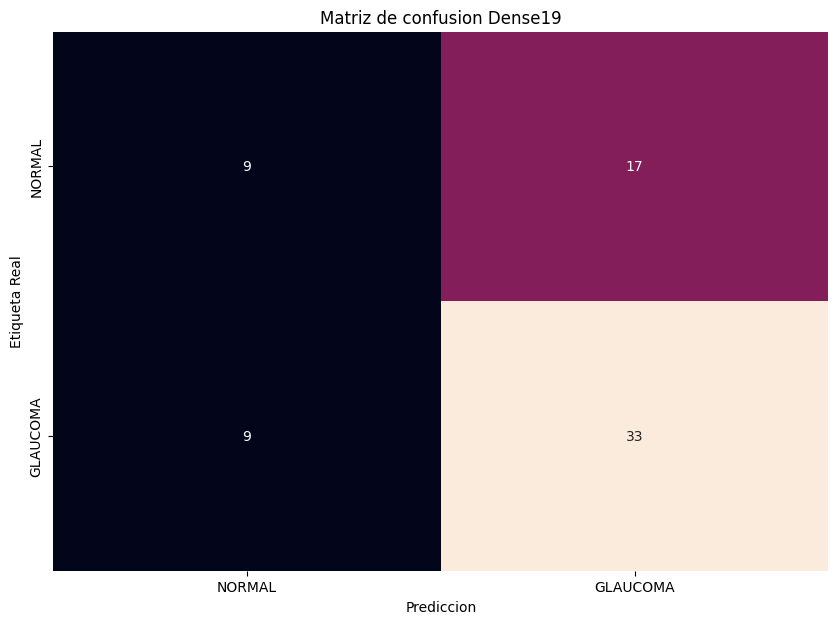

In [36]:
conf_matrix_Dense19 = confusion_matrix(y_true_le, y_pred_ds_Dense19)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_Dense19, annot=True, fmt='d', cbar=False, xticklabels=['NORMAL', 'GLAUCOMA'], yticklabels=['NORMAL', 'GLAUCOMA'])
plt.xlabel('Prediccion')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de confusion Dense19')
plt.show()

### ROC curve for DS_Dense19

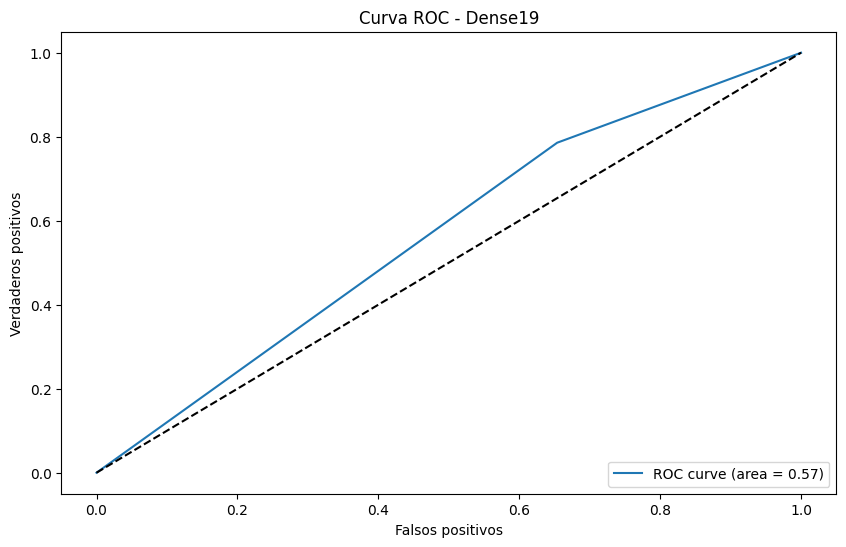

In [40]:
fpr_d19, tpr_d19, thresholds = roc_curve(y_true_le, y_pred_ds_Dense19)

auc_d19 = roc_auc_score(y_true_le, y_pred_ds_Dense19) #Curva roc

# Crear una figura
plt.figure(figsize=(10, 6))
plt.plot(fpr_d19, tpr_d19, label='ROC curve (area = %0.2f)' % auc_d19)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Dense19')
plt.legend(loc='lower right')
plt.show()

### Metrics for DS_Dense19

In [46]:
Dense19_metrics = get_metrics(y_true_le, y_pred_ds_Dense19)
Dense19_metrics

{'Accuracy': 0.6176470588235294,
 'Recall': 0.7857142857142857,
 'Precision': 0.66,
 'f1_score': 0.717391304347826,
 'Specificity': 0.34615384615384615,
 'Error rate': 0.38235294117647056}

In [49]:
densenet_metrics

{'Accuracy': 0.6176470588235294,
 'Recall': 0.8095238095238095,
 'Precision': 0.6538461538461539,
 'f1_score': 0.723404255319149,
 'Specificity': 0.3076923076923077,
 'Error rate': 0.38235294117647056}

In [48]:
conf_matrix_Dense19

array([[ 9, 17],
       [ 9, 33]], dtype=int64)